In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Auxiliary Functions

In [ ]:
def retrieve_data(path,interval,npoints,sufix=""):
  dfTrain = pd.DataFrame()
  dfTest = pd.DataFrame()
  for idx in range(npoints):
    df = pd.read_csv(path+'train'+str(idx)+'_'+str(interval)+sufix+'.csv',index_col=0)
    df['batch_index'] = idx
    dfTrain = pd.concat([dfTrain, df], ignore_index=True)
  for idx in range(npoints):
    df = pd.read_csv(path+'test'+str(idx)+'_'+str(interval)+sufix+'.csv',index_col=0)
    df['batch_index'] = idx
    dfTest = pd.concat([dfTest, df], ignore_index=True)
  dfAccTrain = pd.read_csv(path+'train_accuracy_'+str(interval)+sufix+'.csv',index_col=0)
  dfAccTest = pd.read_csv(path+'test_accuracy_'+str(interval)+sufix+'.csv',index_col=0)
  return dfTrain,dfTest,dfAccTrain,dfAccTest

def format_data(dfTrain,dfTest,dfAccTrain,dfAccTest,in_percentage=True):
  dfTrain["epoch"] +=1
  dfTest["epoch"] +=1
  dfAccTrain["epoch"] +=1
  dfAccTest["epoch"] +=1

  for epoch in dfTrain["epoch"].unique():
    for batch_index in dfTrain["batch_index"].unique():
      for metric in dfTrain["metric"].unique():
        newDf = pd.DataFrame({"epoch":epoch, "layer":"erro","metric":metric,"batch_index":batch_index,"value":np.nan},index=[0])
        dfTrain = pd.concat([dfTrain,newDf],ignore_index=True,axis=0)
        dfTest = pd.concat([dfTest,newDf],ignore_index=True,axis=0)

  dfAccTrainFormat = dfTrain.copy(deep=True)
  dfAccTrainFormat["value"] = np.nan
  for _,r in dfAccTrain.iterrows():
    dfAccTrainFormat.loc[(dfAccTrainFormat["epoch"]==r['epoch']) & (dfAccTrainFormat["layer"]=='erro'),'value'] = 1- r['value']

  dfAccTestFormat = dfTest.copy(deep=True)
  dfAccTestFormat["value"] = np.nan
  for _,r in dfAccTest.iterrows():
    dfAccTestFormat.loc[(dfAccTestFormat["epoch"]==r['epoch']) & (dfAccTestFormat["layer"]=='erro'),'value'] = 1- r['value']

  if in_percentage:
    dfTrain['value'] = 100*dfTrain['value']
    dfTest['value'] = 100*dfTest['value']
    dfAccTrainFormat['value'] = 100*dfAccTrainFormat['value']
    dfAccTestFormat['value'] = 100*dfAccTestFormat['value']

  return dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat


In [ ]:
def plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="",remove_l1=True):
  palette_colors = sns.color_palette("Paired",len(dfTrain['epoch'].unique()))
  palette_dict = {epoch: color for epoch, color in zip(dfTrain['epoch'].unique(), palette_colors)}

  metrics = list(dfTrain['metric'].unique())
  if ('l1' in metrics) & remove_l1:
    metrics.remove('l1')

  dfTrain.rename(columns={"epoch": "Época", "layer": "Camada"},inplace=True)
  dfTest.rename(columns={"epoch": "Época", "layer": "Camada"},inplace=True)
  dfAccTrainFormat.rename(columns={"epoch": "Época", "layer": "Camada"},inplace=True)
  dfAccTestFormat.rename(columns={"epoch": "Época", "layer": "Camada"},inplace=True)
  nplots = len(metrics);
  fig, ax = plt.subplots(nplots,2,figsize=figsize)
  for i,metric in enumerate(metrics):
    ax1 = ax[0] if (nplots == 1) else ax[i,0]
    sns.lineplot(data=dfTrain[dfTrain.metric == metric],
                x="Camada",y="value",hue="Época", ax=ax1,
                err_style='bars',errorbar='sd',palette=palette_dict).set(title=legends[i][0],ylabel="Medida de complexidade (%)")
    sns.move_legend(ax1, "lower left")
    ax1.set_ylim(100*ylim[i][0], 100*ylim[i][1])
    ax2 = ax1.twinx()
    sns.scatterplot(data=dfAccTrainFormat,y="value",x="Camada",hue="Época",marker="x",
                  palette=palette_dict,ax=ax2).set(ylabel="Erro da rede (%)")
    sns.move_legend(ax2, "lower left")
    ax2.set_ylim(ylimAcc[0],ylimAcc[1])

    ax1 = ax[1] if (nplots == 1) else ax[i,1]
    sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="Camada",y="value",hue="Época",ax=ax1,
               err_style='bars',errorbar='sd',palette=palette_dict).set(title=legends[i][1],ylabel="Medida de complexidade (%)")
    sns.move_legend(ax1, "lower left")
    ax1.set_ylim(100*ylim[i][0], 100*ylim[i][1])
    ax2 = ax1.twinx()
    sns.scatterplot(data=dfAccTestFormat,y="value",x="Camada",hue="Época",marker="x",
                  palette=palette_dict,ax=ax2).set(ylabel="Erro da rede (%)")
    sns.move_legend(ax2, "lower left")
    ax2.set_ylim(ylimAcc[0],ylimAcc[1])
  fig.suptitle(title, fontsize=15)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.show()

# Commom parameters

In [ ]:
legends = [["Medidas de f1 para conjunto de treino","Medidas de f1 para conjunto de teste"],
          #  ["l1 train","l1 test"],
           ["Medidas de n1 para conjunto de treino","Medidas de n1 para conjunto de teste"],
           ["Medidas de n2 para conjunto de treino","Medidas de n2 para conjunto de teste"],
           ["Medidas de n3 para conjunto de treino","Medidas de n3 para conjunto de teste"]]

# LeNet5_MNIST

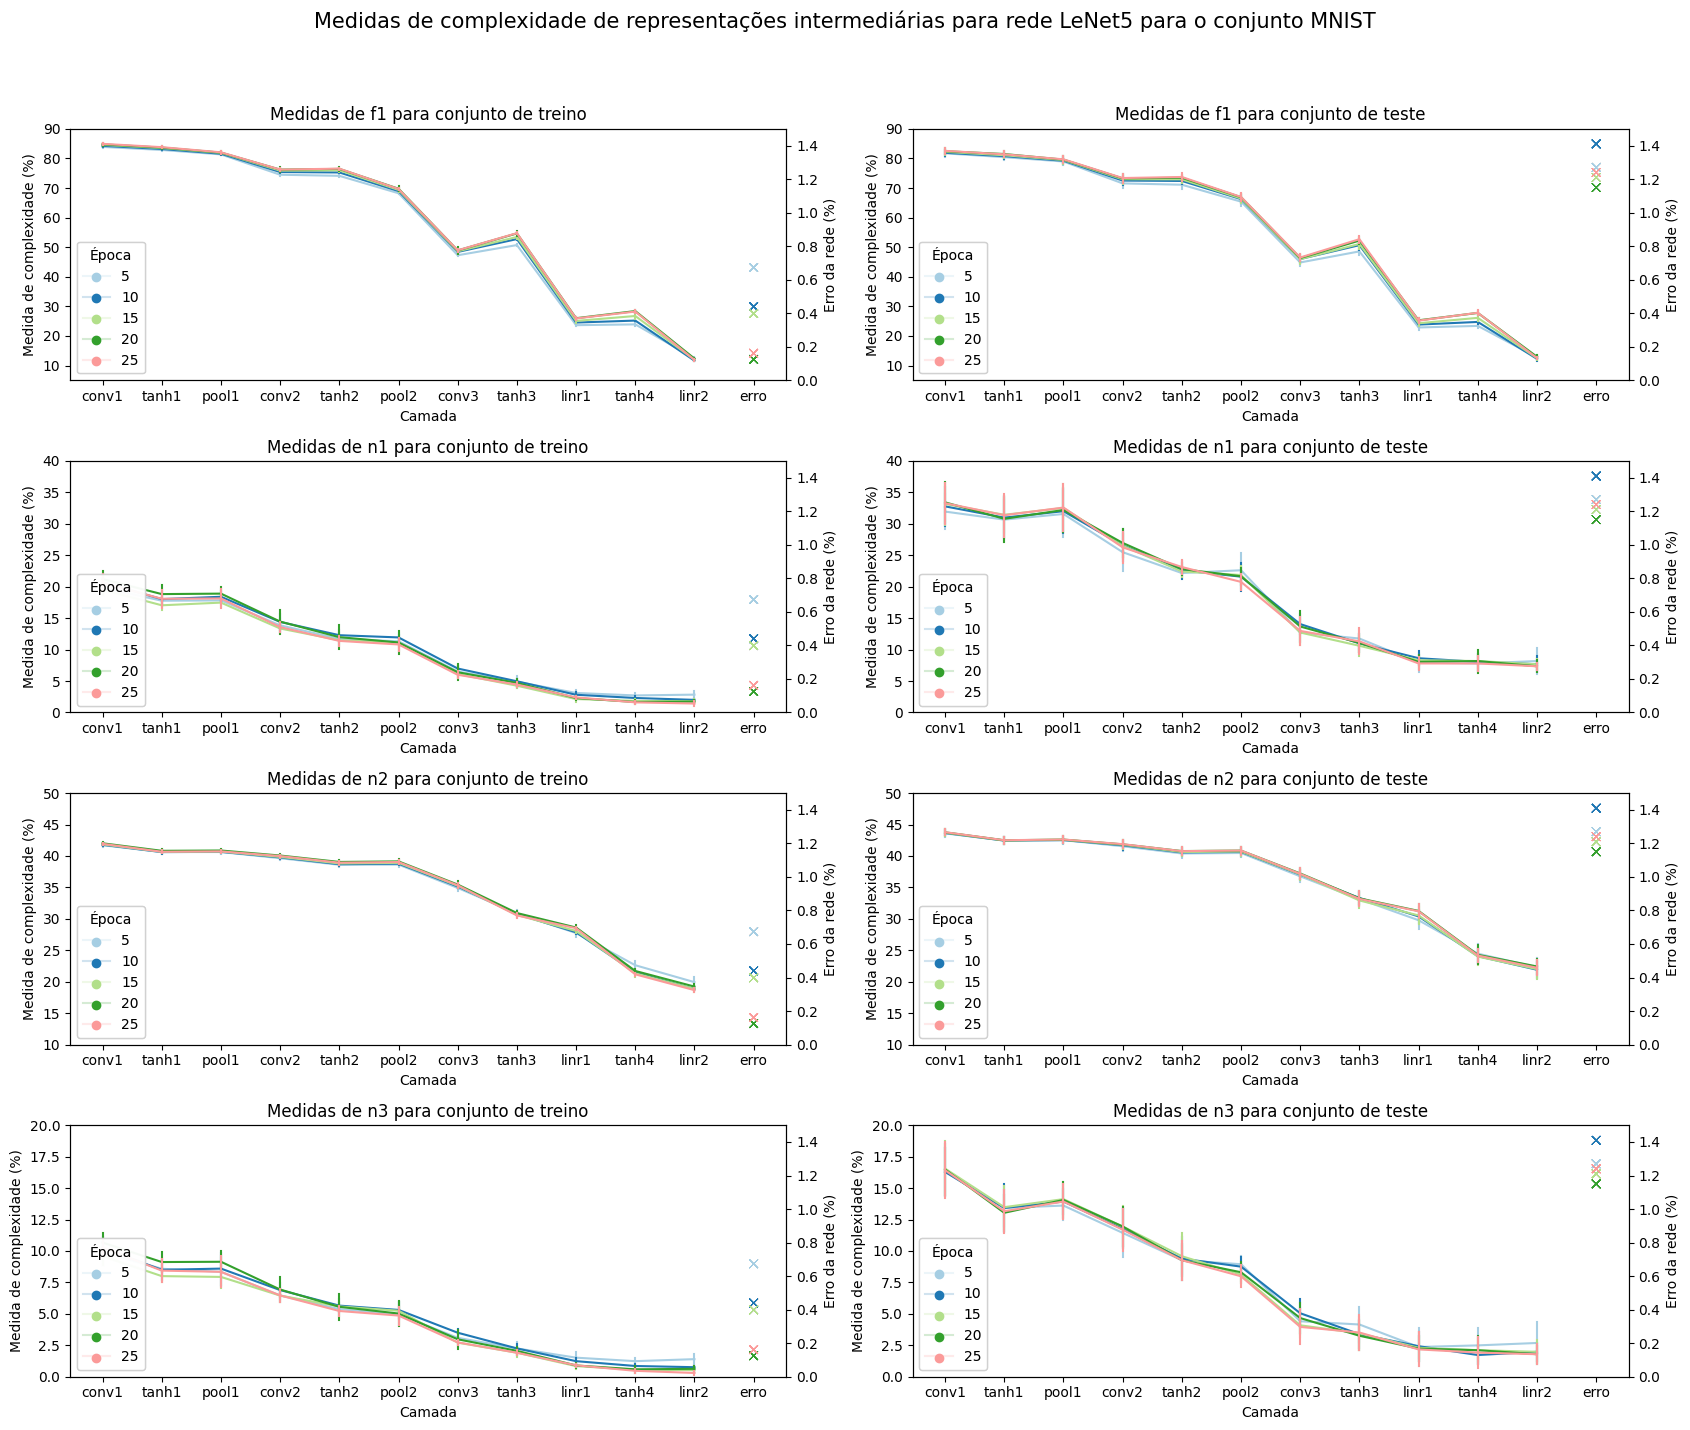

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST/',5,5)
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.05,.9], # f1
      # [-.0001,0.0002], #l1
      [.0,.4], #n1
      [.1,.5], #n2
      [.0,.2] #n3
      ]

ylimAcc=[.0,1.5]
legends = [["Medidas de f1 para conjunto de treino","Medidas de f1 para conjunto de teste"],
          #  ["l1 train","l1 test"],
           ["Medidas de n1 para conjunto de treino","Medidas de n1 para conjunto de teste"],
           ["Medidas de n2 para conjunto de treino","Medidas de n2 para conjunto de teste"],
           ["Medidas de n3 para conjunto de treino","Medidas de n3 para conjunto de teste"]]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="Medidas de complexidade de representações intermediárias para rede LeNet5 para o conjunto MNIST")
plt.savefig('LeNet5MNIST.png', bbox_inches='tight')

# LeNet5_MNIST_Dropout

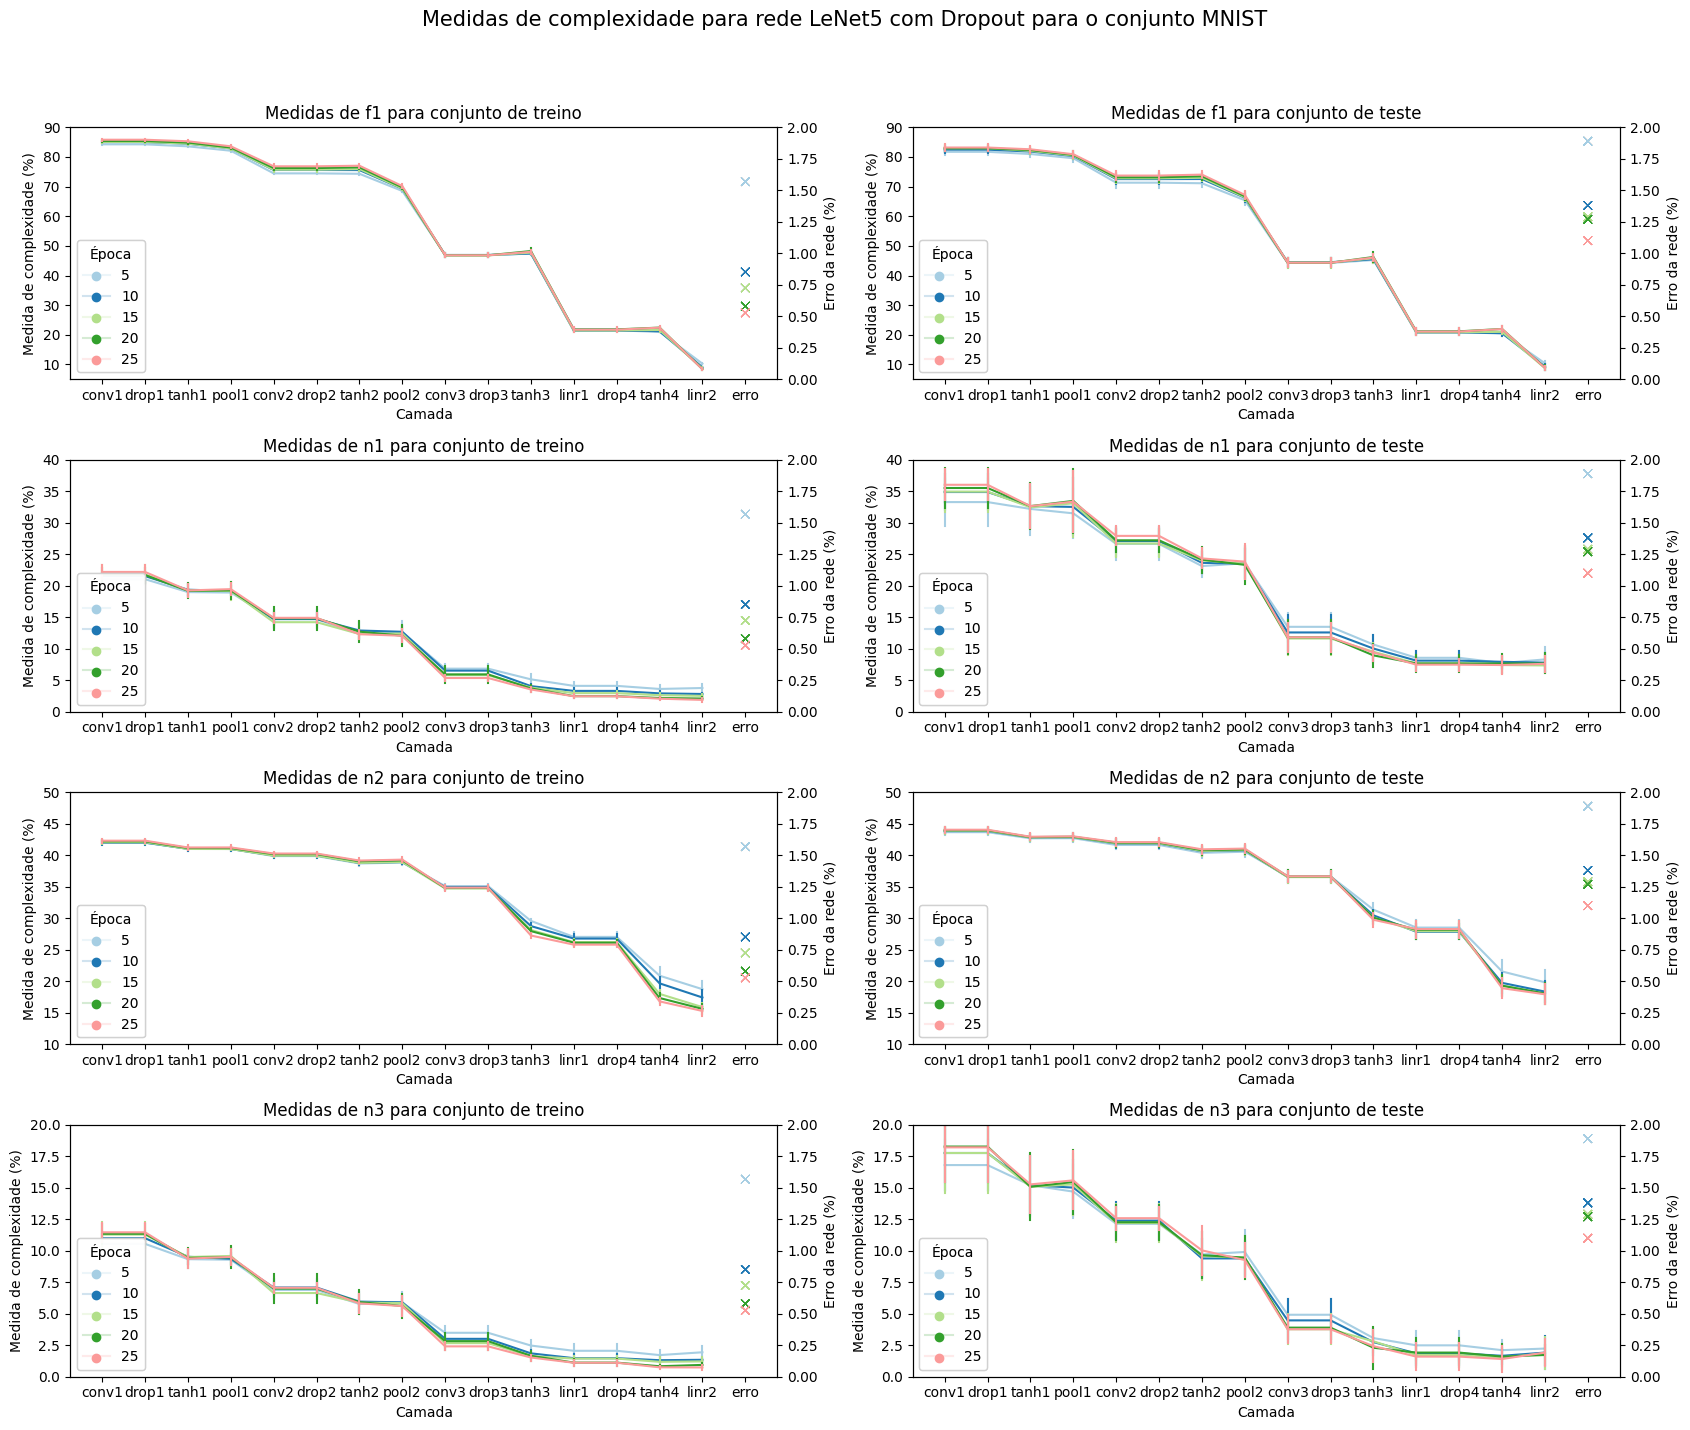

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',5,5,sufix="_dropout")
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.05,.9], # f1
      # [-.0001,0.0006], #l1
      [.0,.4], #n1
      [.1,.5], #n2
      [.0,.2] #n3
      ]
ylimAcc=[.0,2.0]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="Medidas de complexidade para rede LeNet5 com Dropout para o conjunto MNIST")
plt.savefig('LeNetMNISTDropout.png', bbox_inches='tight')

#LeNet5_MNIST N3

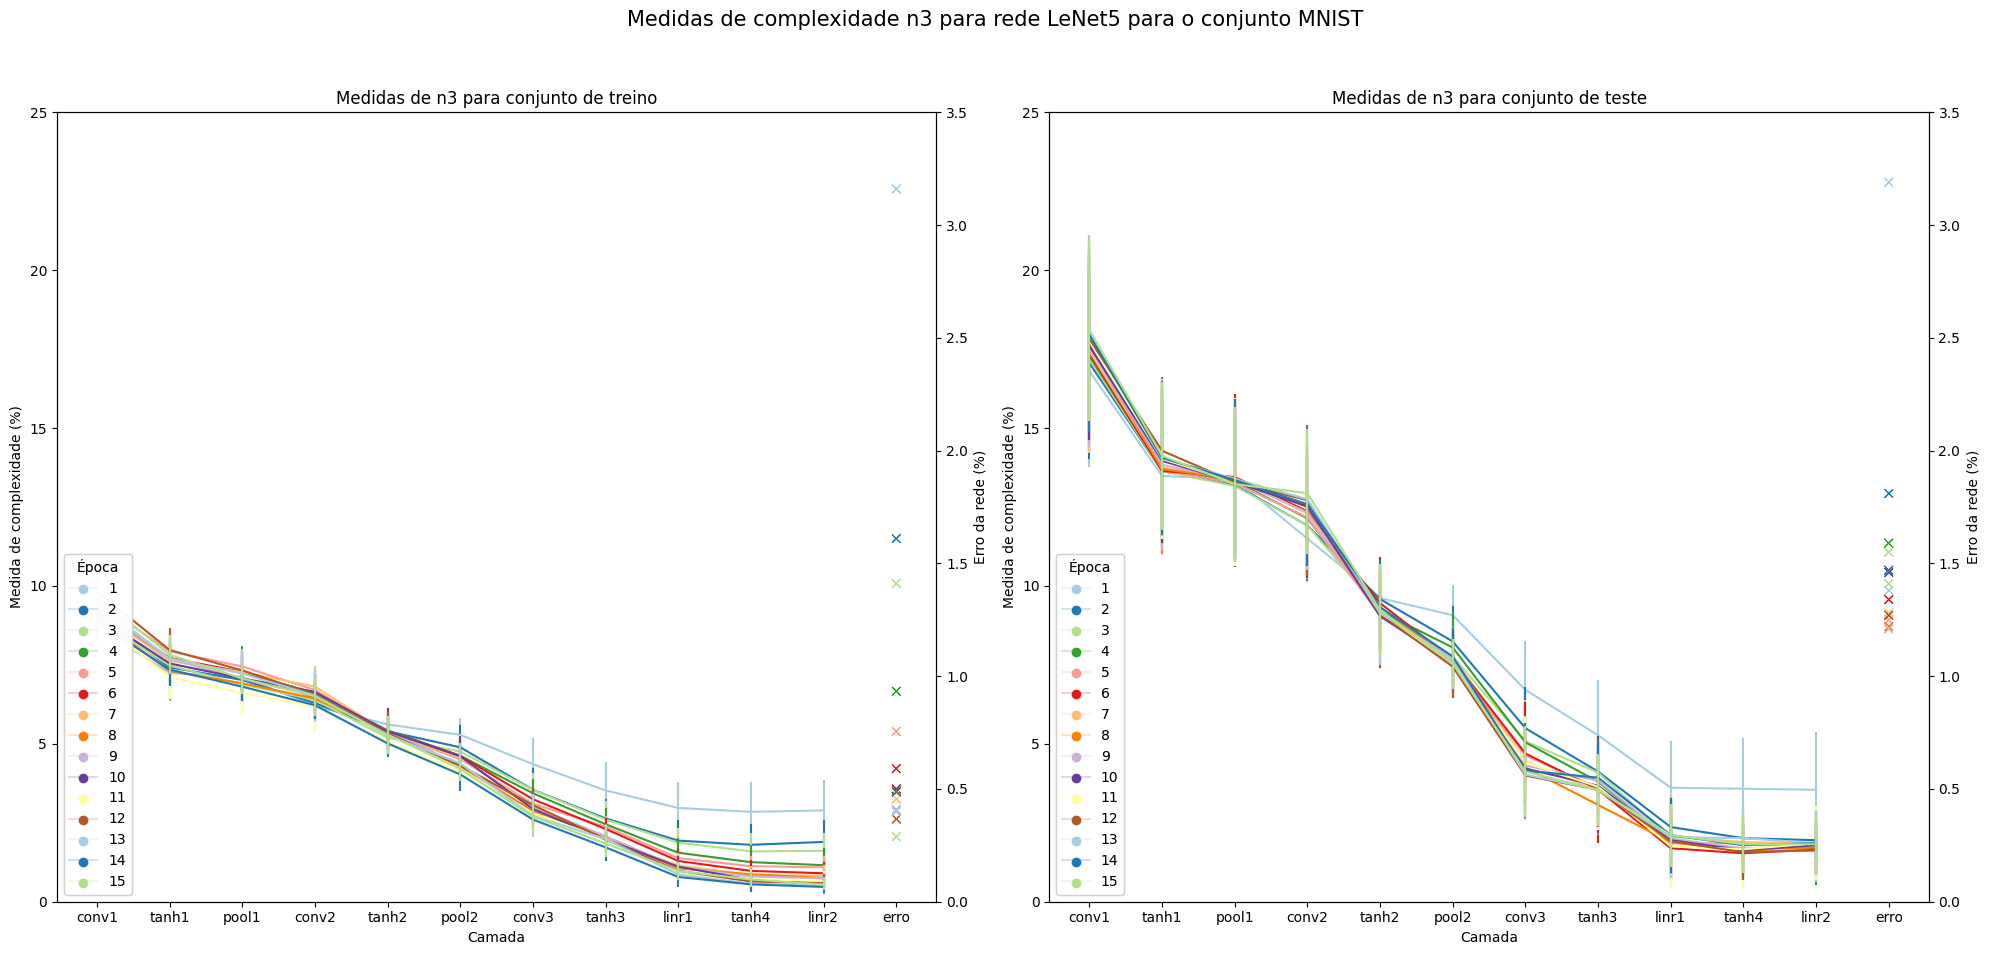

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST/',1,10)
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.0,.25] #n3
      ]
ylimAcc=[.0,3.5]
legendsn3 = [["Medidas de n3 para conjunto de treino","Medidas de n3 para conjunto de teste"]]
figsize=(20,10)
plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legendsn3,title="Medidas de complexidade n3 para rede LeNet5 para o conjunto MNIST")
plt.savefig('LeNet5MNISTN3Tim.png', bbox_inches='tight')

#LeNet5_MNIST_Dropout N3

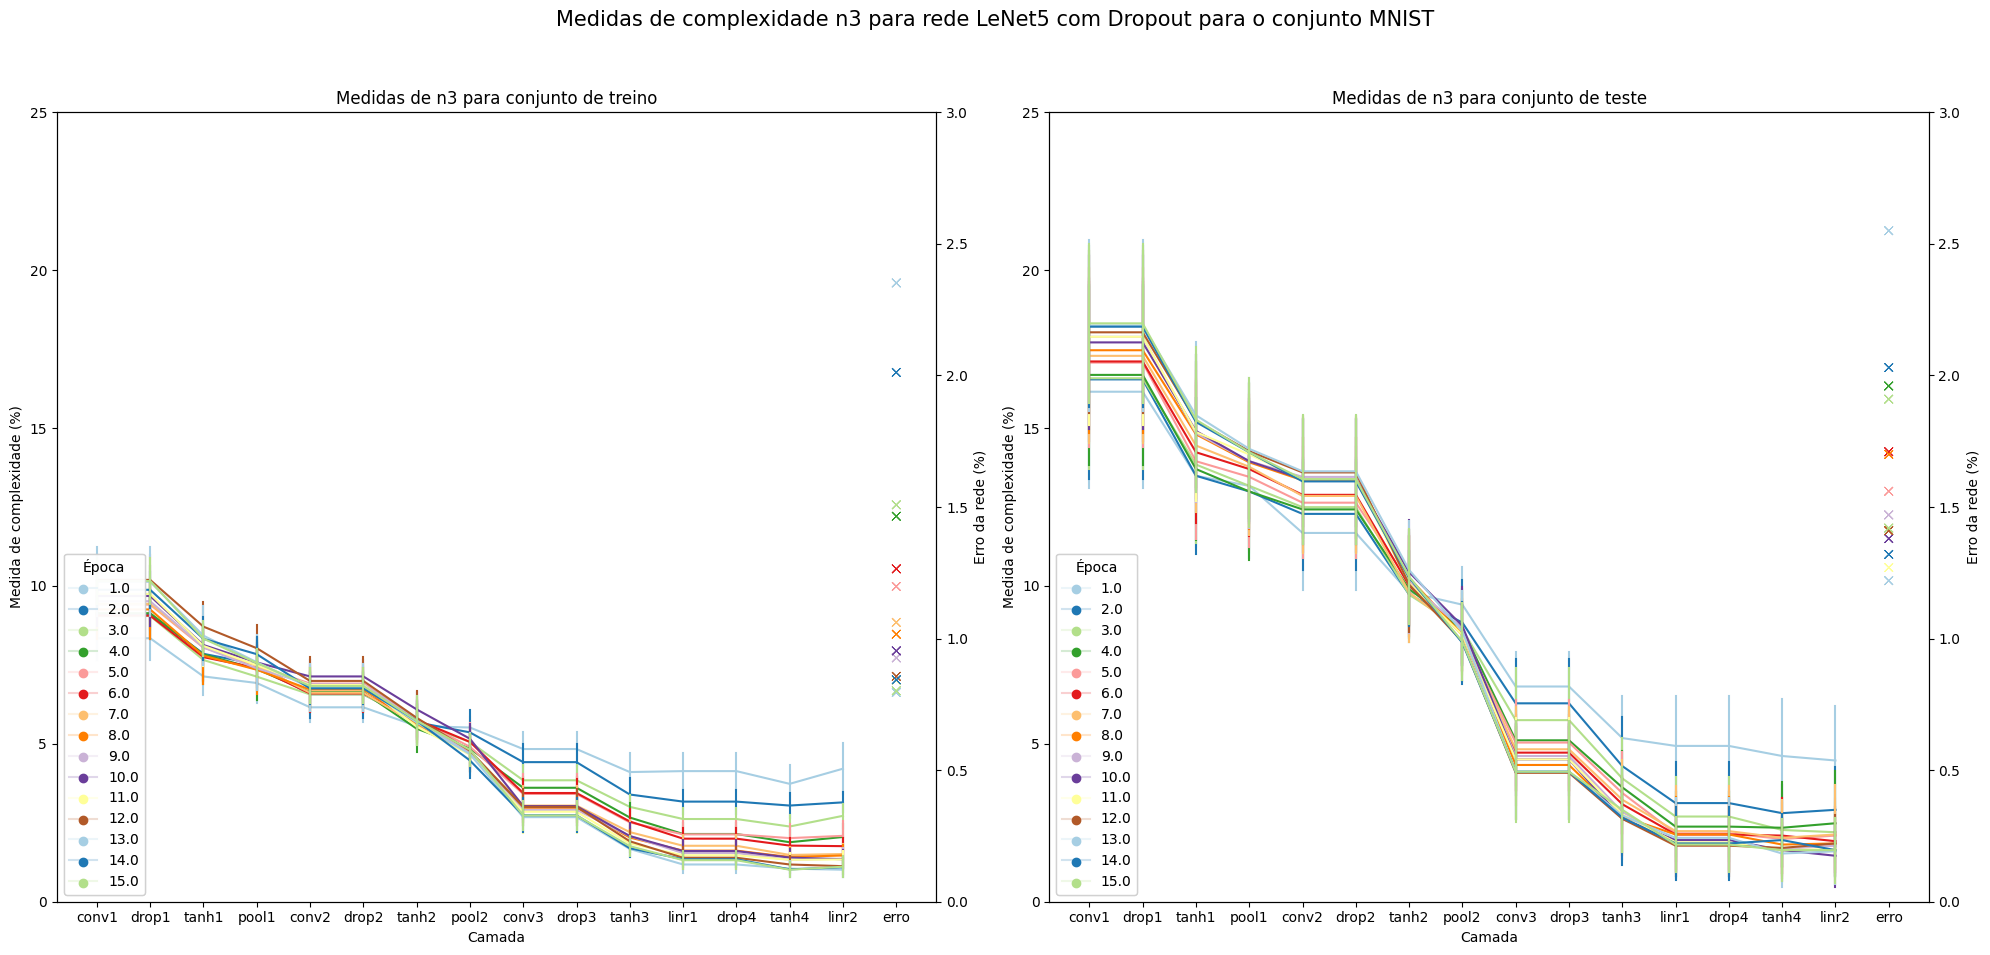

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',1,10,sufix="_dropout")
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.0,.25] #n3
      ]
ylimAcc=[.0,3]
legendsn3 = [["Medidas de n3 para conjunto de treino","Medidas de n3 para conjunto de teste"]]
figsize=(20,10)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legendsn3,title="Medidas de complexidade n3 para rede LeNet5 com Dropout para o conjunto MNIST")
plt.savefig('LeNet5DropoutMNISTN3Tim.png', bbox_inches='tight')

# LeNet5_Cifar100_Vehicles2

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarn

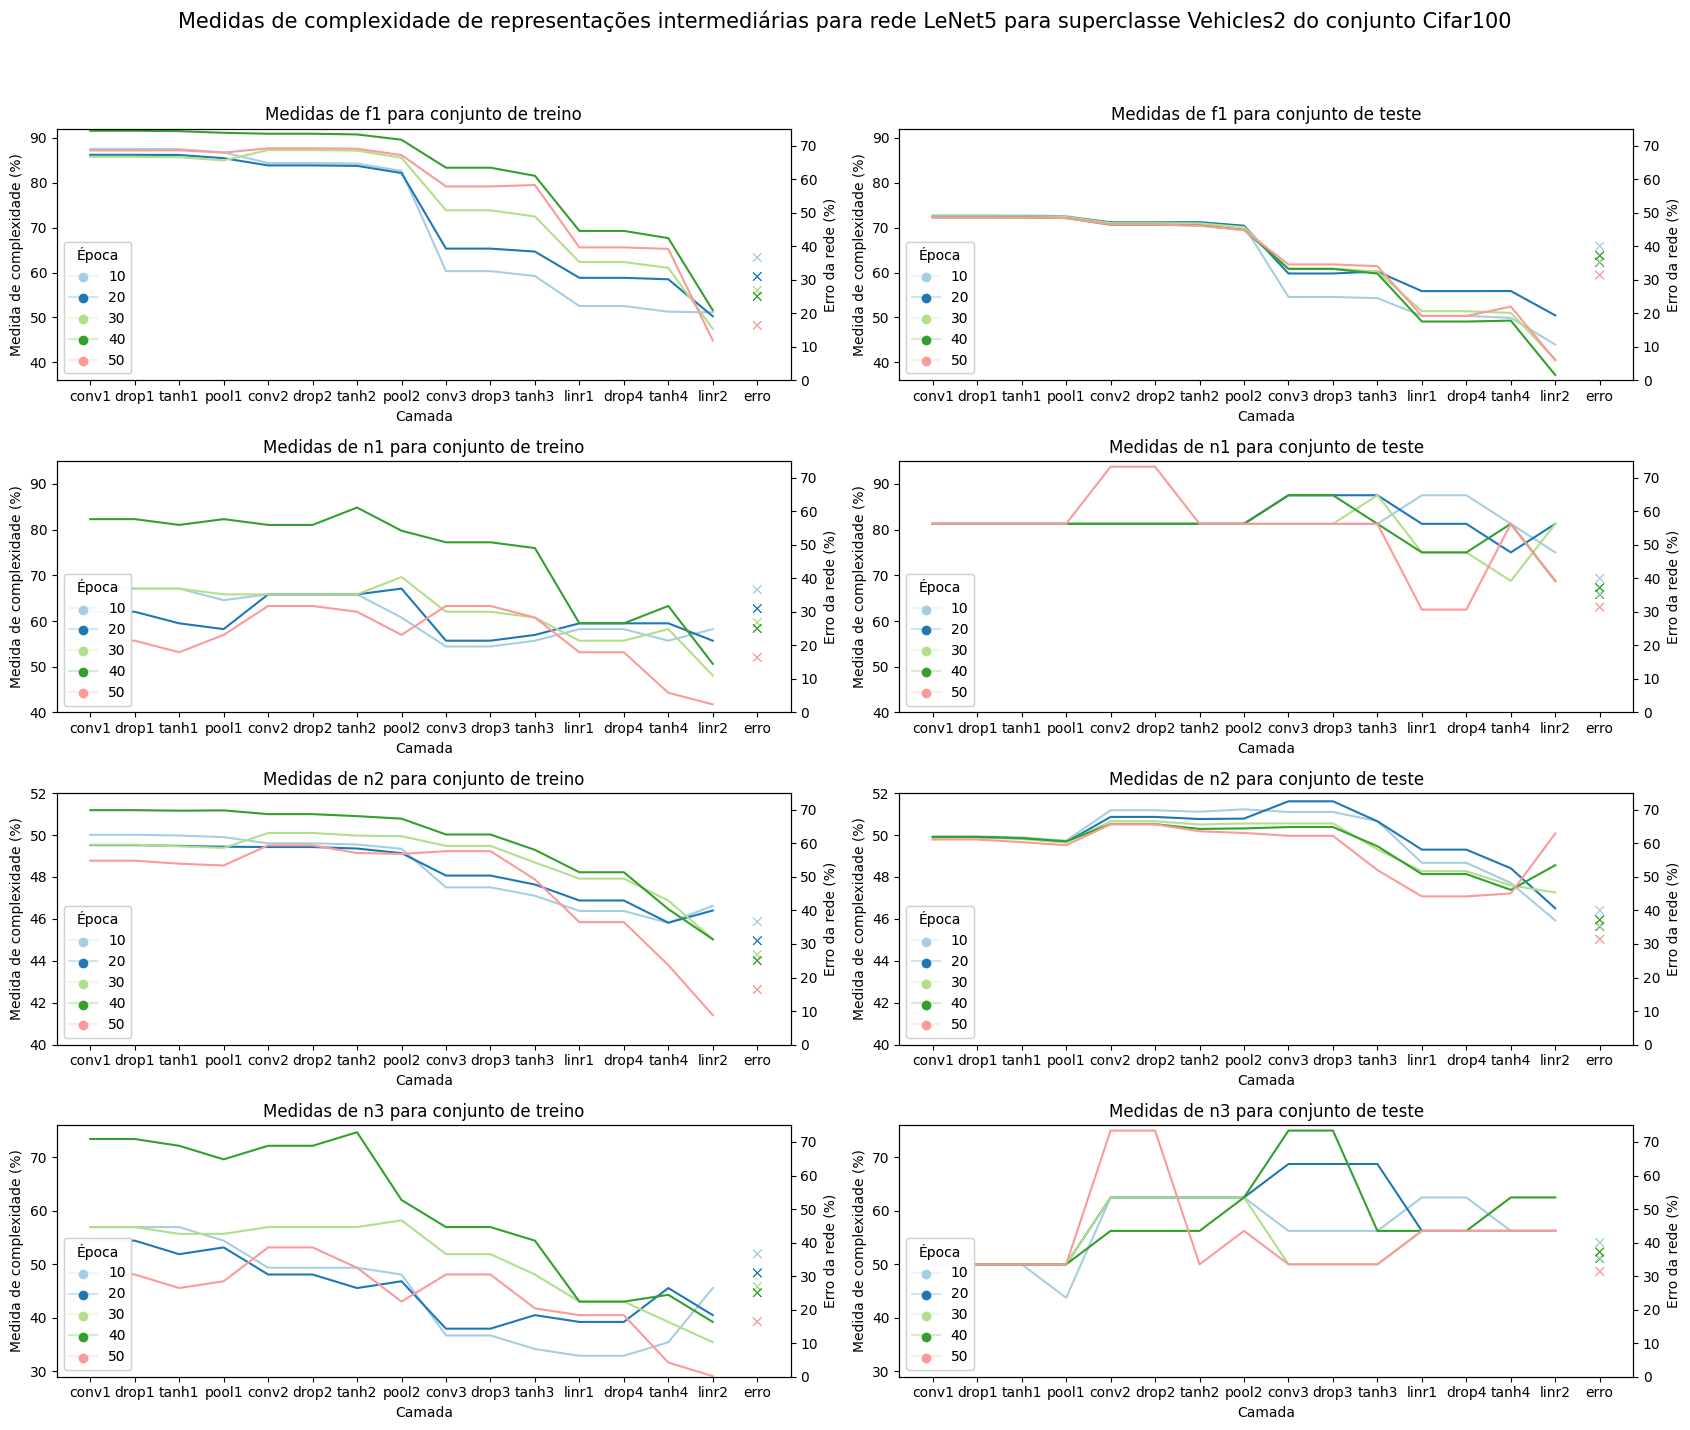

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/',10,1,sufix='_dropout_cifar100_vehicles2')
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.36,.92], # f1
      # [-.0001,0.0002], #l1
      [.40,.95], #n1
      [.40,.52], #n2
      [.29,.76] #n3
      ]

ylimAcc=[.0,75]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="Medidas de complexidade de representações intermediárias para rede LeNet5 para superclasse Vehicles2 do conjunto Cifar100")
plt.savefig('LeNetCifar100Vehicles2Dropout.png', bbox_inches='tight')


# LeNet5_Cifar100_People



/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarn

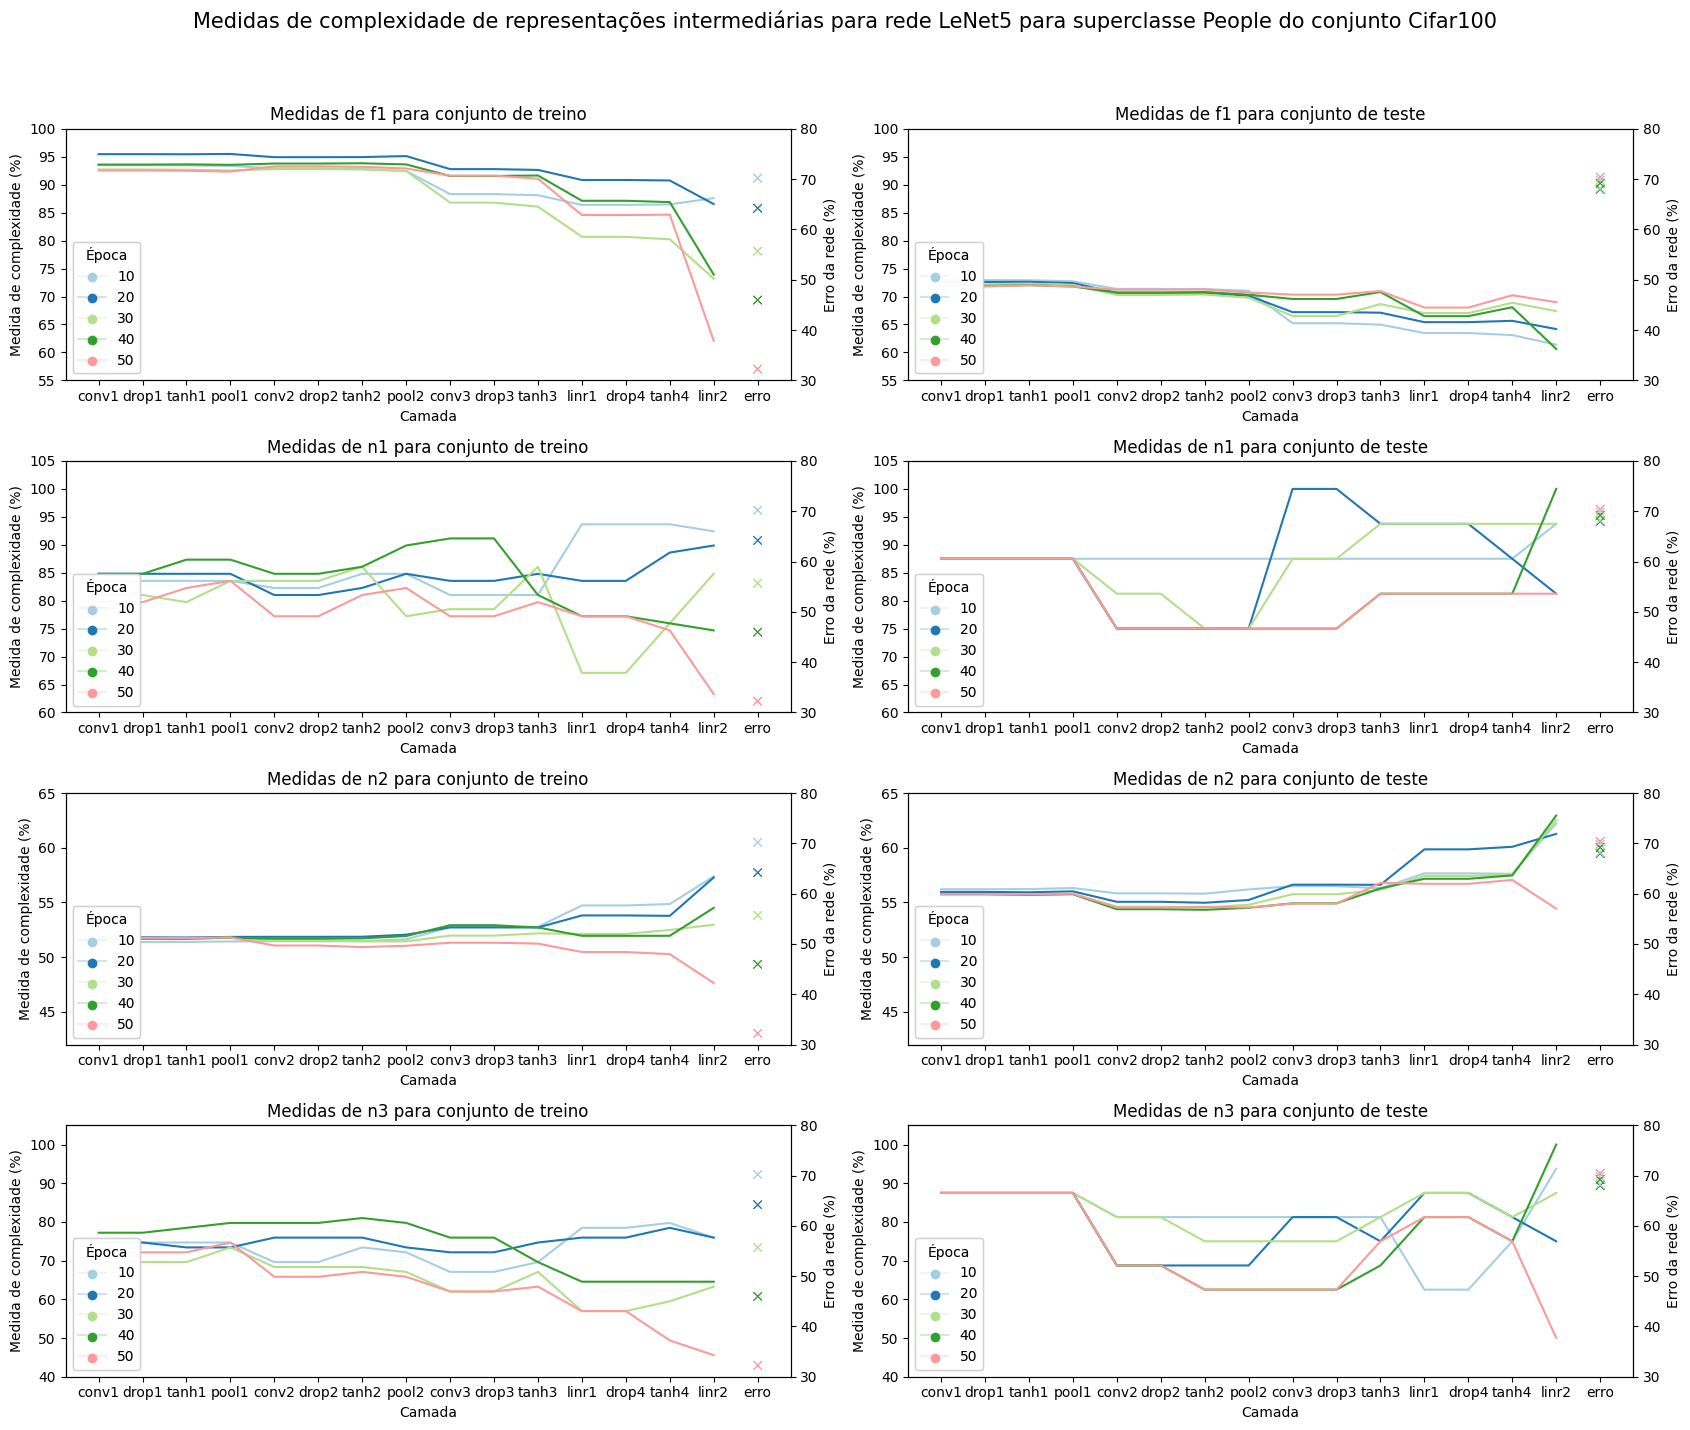

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_Cifar100_People/',10,1,sufix='_dropout_cifar100_people')
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.55,1], # f1
      # [-.0001,0.0002], #l1
      [.6,1.05], #n1
      [.42,.65], #n2
      [.40,1.05] #n3
      ]

ylimAcc=[30,80]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="Medidas de complexidade de representações intermediárias para rede LeNet5 para superclasse People do conjunto Cifar100")
plt.savefig('LeNetCifar100PeopleDropout.png', bbox_inches='tight')

# Accuracy

In [ ]:
def retrieve_acc_data(path,interval,nepochs,sufix=""):
  dfAccTrain = pd.read_csv(path+'train_accuracy_'+str(interval)+'_'+str(nepochs)+sufix+'.csv',index_col=0)
  dfAccTest = pd.read_csv(path+'test_accuracy_'+str(interval)+'_'+str(nepochs)+sufix+'.csv',index_col=0)
  dfAccTrain["epoch"] +=1
  dfAccTest["epoch"] +=1
  dfAccTrain["value"] *= 100
  dfAccTest["value"] *= 100
  return dfAccTrain,dfAccTest

def plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title=""):
  fig, ax = plt.subplots(figsize=figsize)
  concatenated = pd.concat([dfAccTrain.assign(dataset='Treino'), dfAccTest.assign(dataset='Teste')])
  ax = sns.lineplot(data=concatenated,x='epoch',y='value',hue='dataset').set(ylabel='Acurácia (%)',xlabel='Época')
  fig.suptitle(title, fontsize=15)

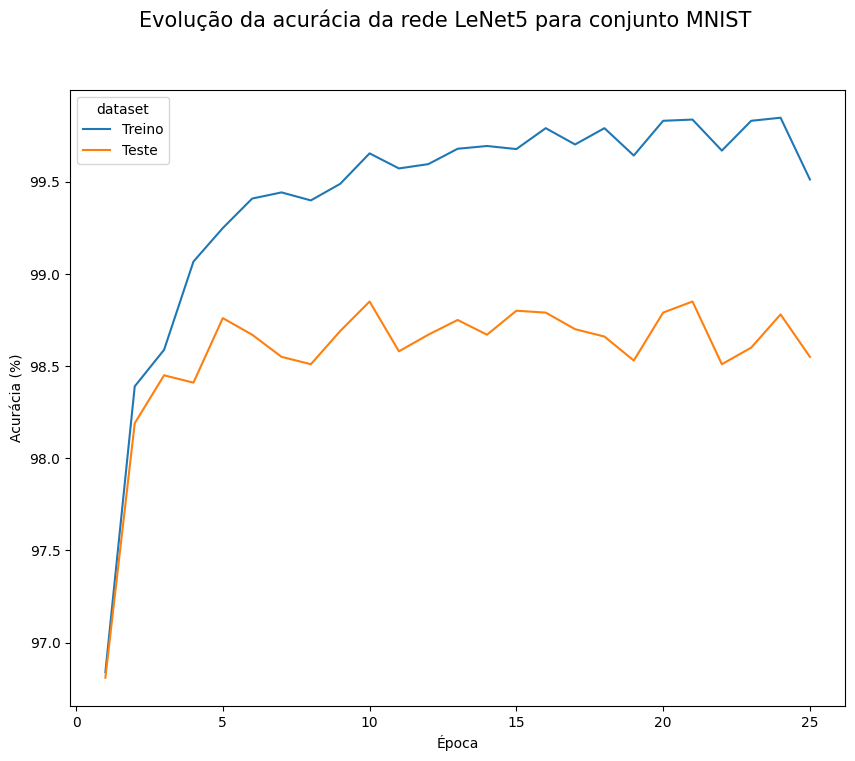

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_MNIST/',1,25)
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Evolução da acurácia da rede LeNet5 para conjunto MNIST")
plt.savefig('AccLeNet5MNIST.png', bbox_inches='tight')

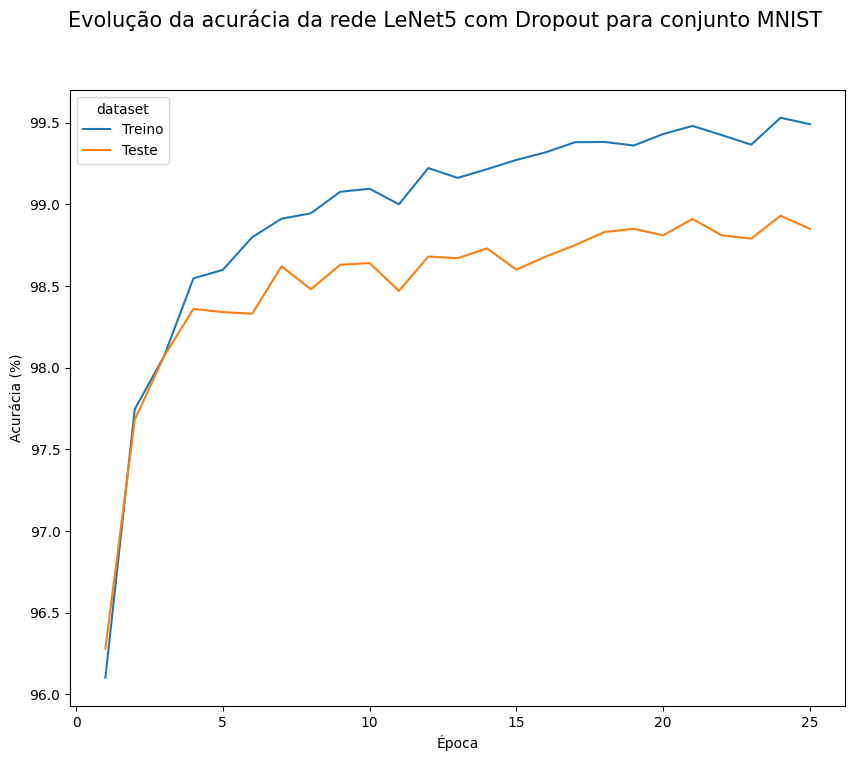

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',1,25,sufix='_dropout')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Evolução da acurácia da rede LeNet5 com Dropout para conjunto MNIST")
plt.savefig('AccLeNet5DropoutMNIST.png', bbox_inches='tight')

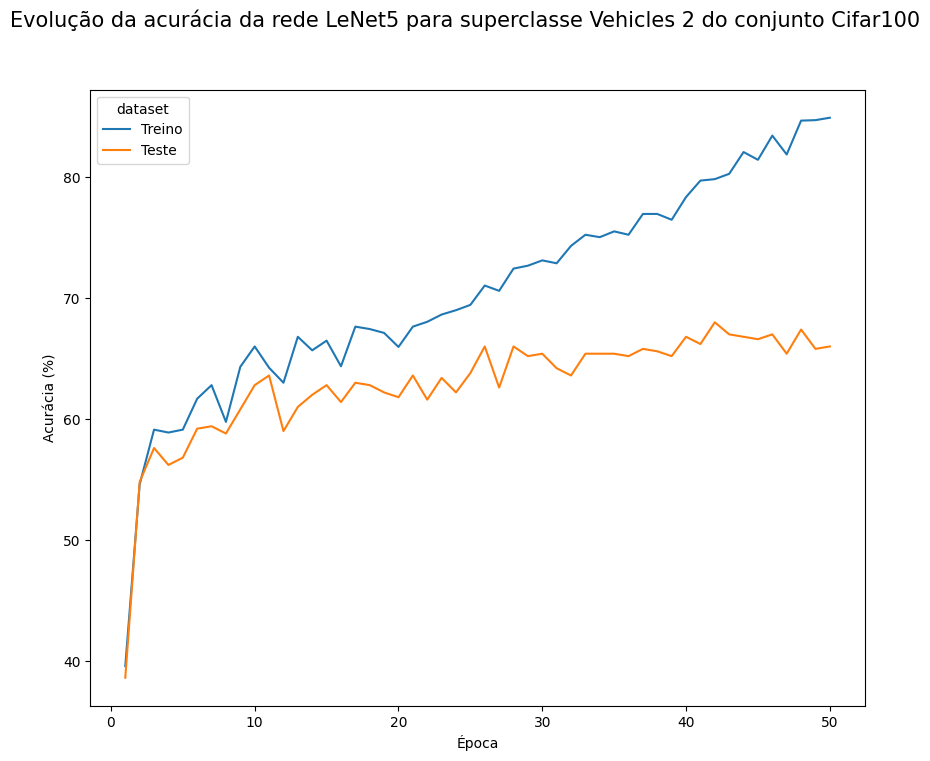

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/',1,50,sufix='_dropout_cifar100_vehicles2')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Evolução da acurácia da rede LeNet5 para superclasse Vehicles 2 do conjunto Cifar100")
plt.savefig('AccLeNet5DropoutCifar100Vehicles2.png', bbox_inches='tight')

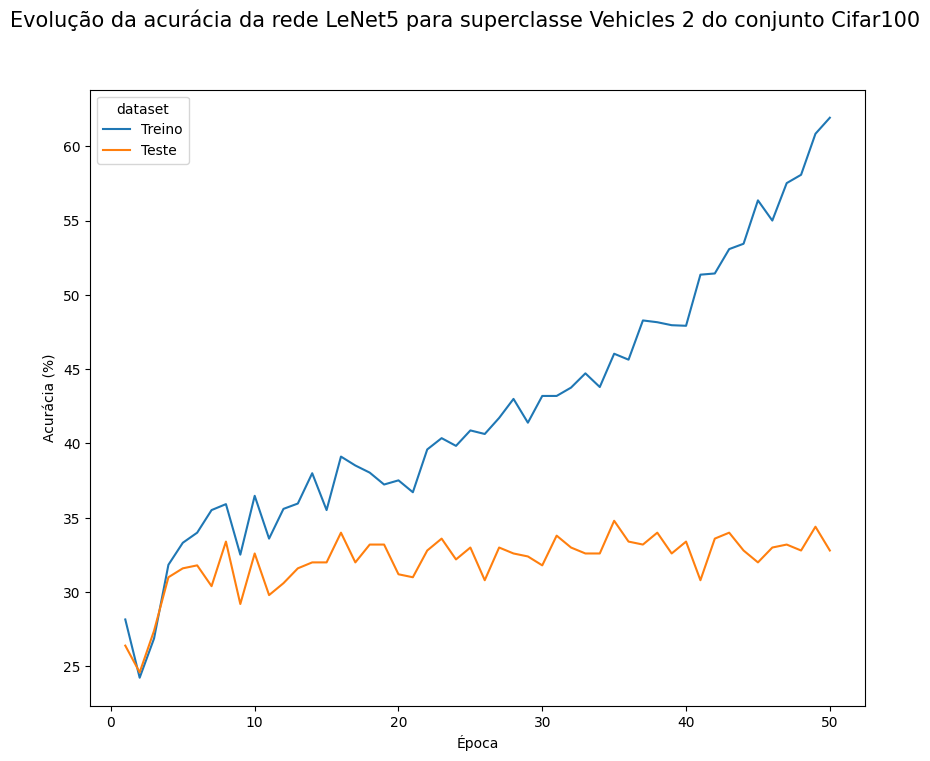

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_Cifar100_People/',1,50,sufix='_dropout_cifar100_people')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Evolução da acurácia da rede LeNet5 para superclasse Vehicles 2 do conjunto Cifar100")
plt.savefig('AccLeNet5DropoutCifar100People.png', bbox_inches='tight')